In [1]:
import ND_north_star.src.noise_generators.perlin_noise_generator as PNG

import ND_north_star.src.edge_detection.complex as ED_com
import ND_north_star.src.edge_detection.gradient_detection as ED_sim


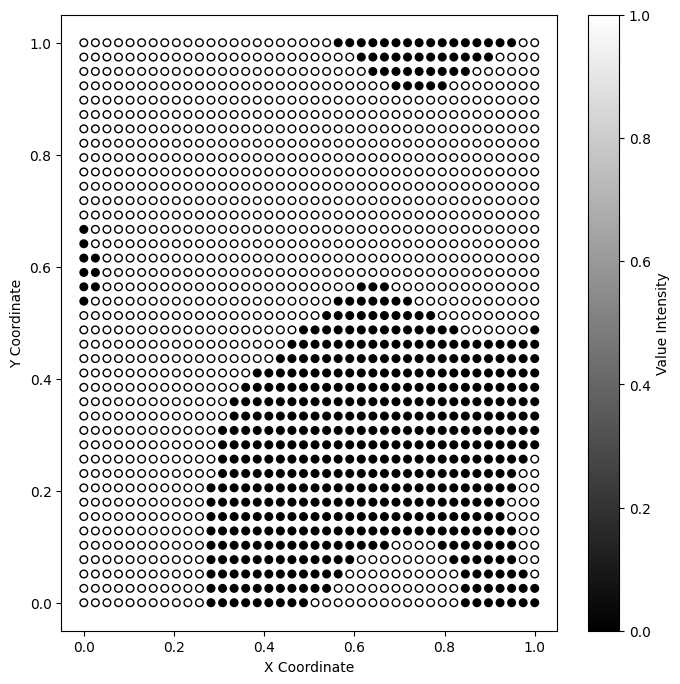

In [2]:
resolution = 40
dimensions = [resolution, resolution]


dataset = PNG.normalized_perlin_data(dimensions, 2)

# Plot perlin noise coord in x and y coordinates and with intensity values surrounded by a black outline
PNG.plot_perlin_2D_3D(dataset, 'black')

In [3]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

def identify_boundary_points(data, labels, n_neighbors=5):
    boundary_points = []
    for idx, point in enumerate(data):
        if labels[idx] == 1:
            neighbors = NearestNeighbors(n_neighbors=n_neighbors).fit(data).kneighbors([point], return_distance=False)
            if any(labels[neighbor] == 0 for neighbor in neighbors[0]):
                boundary_points.append(point)
    return np.array(boundary_points)

# Example usage
data = dataset['features']  # Your N-dimensional data points
labels = dataset['values']  # Your corresponding labels (1 or 0)
boundary_points = identify_boundary_points(data, labels, 5)


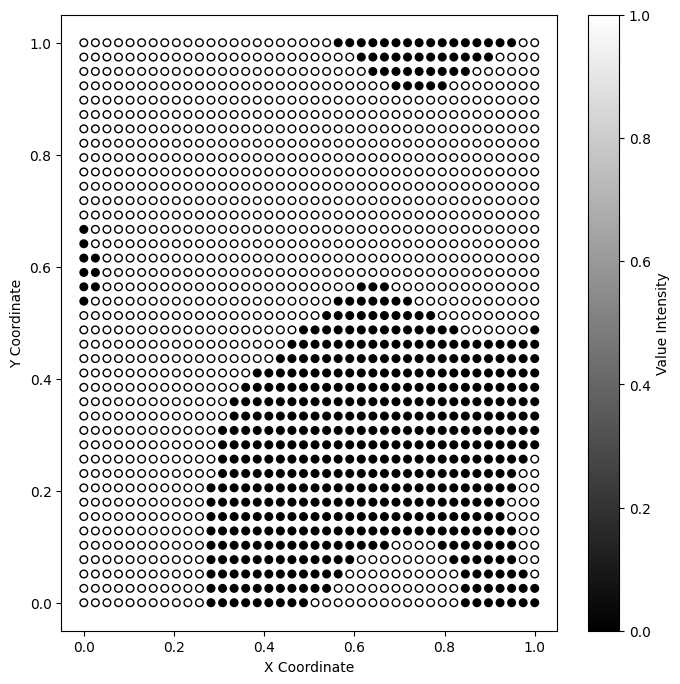

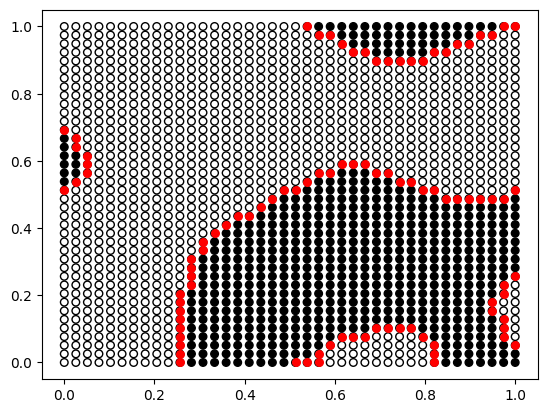

In [4]:
import numpy as np
import matplotlib.pyplot as plt

PNG.plot_perlin_2D_3D(dataset, 'black')

data = np.array(data)

if resolution < 100:
    marker_scale = resolution
else:
    marker_scale = 4*resolution

# Scatter plot
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='gray', s=1200/marker_scale, edgecolors='black')
plt.scatter(boundary_points[:, 0], boundary_points[:, 1], c='red', s=1200/marker_scale)

plt.show()


In [5]:
print(boundary_points)

[[0.         0.51282051]
 [0.         0.69230769]
 [0.02564103 0.53846154]
 [0.02564103 0.64102564]
 [0.02564103 0.66666667]
 [0.05128205 0.56410256]
 [0.05128205 0.58974359]
 [0.05128205 0.61538462]
 [0.25641026 0.        ]
 [0.25641026 0.02564103]
 [0.25641026 0.05128205]
 [0.25641026 0.07692308]
 [0.25641026 0.1025641 ]
 [0.25641026 0.12820513]
 [0.25641026 0.15384615]
 [0.25641026 0.17948718]
 [0.25641026 0.20512821]
 [0.28205128 0.23076923]
 [0.28205128 0.25641026]
 [0.28205128 0.28205128]
 [0.28205128 0.30769231]
 [0.30769231 0.33333333]
 [0.30769231 0.35897436]
 [0.33333333 0.38461538]
 [0.35897436 0.41025641]
 [0.38461538 0.43589744]
 [0.41025641 0.43589744]
 [0.43589744 0.46153846]
 [0.46153846 0.48717949]
 [0.48717949 0.51282051]
 [0.51282051 0.        ]
 [0.51282051 0.51282051]
 [0.53846154 0.        ]
 [0.53846154 0.53846154]
 [0.53846154 1.        ]
 [0.56410256 0.        ]
 [0.56410256 0.02564103]
 [0.56410256 0.56410256]
 [0.56410256 0.97435897]
 [0.58974359 0.05128205]


[]


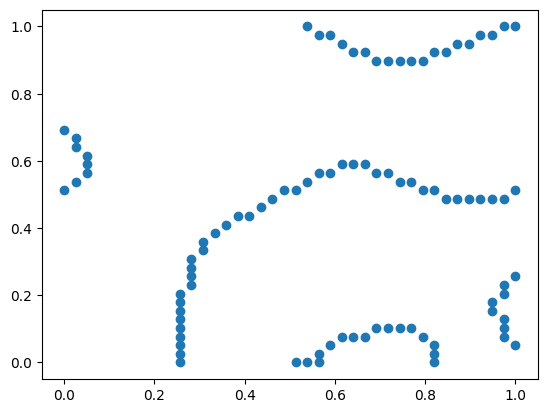

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from scipy.spatial import Delaunay

def alpha_shape(points, alpha):
    if len(points) < 4:
        # When there are less than 4 points, the boundary is the convex hull.
        return Delaunay(points).convex_hull

    def add_edge(edges, edge_points, coords, i, j):
        """
        Add a line between the i-th and j-th points, if not in the list already.
        """
        if (i, j) in edges or (j, i) in edges:
            # already added
            return
        edges.add((i, j))
        edge_points.append(coords[[i, j]])

    coords = np.array(points)
    tri = Delaunay(coords)
    edges = set()
    edge_points = []

    # Loop over triangles:
    # ia, ib, ic are indices of corner points of the triangle.
    for ia, ib, ic in tri.simplices:
        pa = coords[ia]
        pb = coords[ib]
        pc = coords[ic]

        # Compute lengths of sides of triangle
        a = np.linalg.norm(pa - pb)
        b = np.linalg.norm(pb - pc)
        c = np.linalg.norm(pc - pa)

        # Compute circumradius
        s = (a + b + c) / 2.0
        area = np.sqrt(s * (s - a) * (s - b) * (s - c))
        circum_r = a * b * c / (4.0 * area)

        if circum_r < alpha:
            add_edge(edges, edge_points, coords, ia, ib)
            add_edge(edges, edge_points, coords, ib, ic)
            add_edge(edges, edge_points, coords, ic, ia)

    return edge_points

def find_boundaries(points, alpha, eps=0.05, min_samples=5):
    # Cluster the points using DBSCAN
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(points)
    labels = clustering.labels_

    # Find unique clusters
    unique_labels = set(labels)
    boundaries = []

    for label in unique_labels:
        if label == -1:
            # Noise points, ignored in this context
            continue
        cluster_points = points[labels == label]
        boundary_edges = alpha_shape(cluster_points, alpha)
        boundaries.append(boundary_edges)

    return boundaries


alpha = 0.05  # This parameter needs to be tuned
boundaries = find_boundaries(boundary_points, alpha)

print(boundaries)

# Plot the points and the boundaries
plt.figure()
plt.plot(boundary_points[:, 0], boundary_points[:, 1], 'o')
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
for i, boundary_edges in enumerate(boundaries):
    color = colors[i % len(colors)]
    for edge in boundary_edges:
        plt.plot(edge[:, 0], edge[:, 1], color+'-')
plt.show()
